uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 10

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 2000 if not smoke_test else 100 # number of captchas generated for training
hidden_state_dim = 32

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 681
text 22 captcha shape (32, 100) noise 0.4141340735013239
text 22 captcha shape (32, 100) noise 0.9115093514578135
text 52 captcha shape (32, 100) noise 0.2521128139097102
text 17 captcha shape (32, 100) noise 0.032596347399690855
text 49 captcha shape (32, 100) noise 0.29280564634213213
text 71 captcha shape (32, 100) noise 0.431929458497583
text 63 captcha shape (32, 100) noise 0.1405360943077972
text 26 captcha shape (32, 100) noise 0.24992302391928442
text 10 captcha shape (32, 100) noise 0.5312139351401207
text 44 captcha shape (32, 100) noise 0.7702973096507502
text 44 captcha shape (32, 100) noise 0.11546498448623024
number of samples in group 682
text 641 captcha shape (32, 100) noise 0.7541673871205345
text 918 captcha shape (32, 100) noise 0.25877348290715724
text 873 captcha shape (32, 100) noise 0.5221576570502896
text 920 captcha shape (32, 100) noise 0.06816647489535746
text 282 captcha shape (32, 100) noise

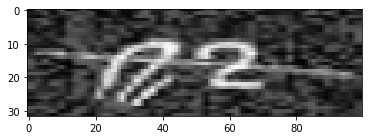

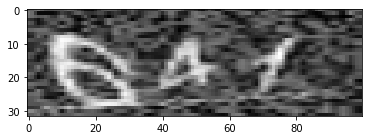

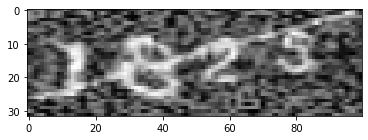

In [3]:
for lst in captcha_generated:
    if len(lst) > 0:
        plt.imshow(lst[0][1], cmap="Greys")
        plt.show()

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.fc20 = nn.Linear(1024, img_size[0] * img_size[1])
        self.fc21 = nn.Linear(img_size[0] * img_size[1], out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        noise_map = self.fc20(F.relu(self.fc2(F.relu(hidden))))
        mean =  self.fc21(F.relu(noise_map))
        # std used in normal distribution
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, noise_map

In [8]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(1280 + hidden_state_dim + 1, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img_embedded, hid, noise_batch):
        
        BATCH_SIZE = img_embedded.shape[0]

        img = torch.cat((img_embedded, hid, noise_batch), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [11]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 1)
        #print(input_x, input_x.shape)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

In [12]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [13]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [14]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        if (t % save_pause == 0) and (t > 0):
            save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [15]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_char_accuracies
    }
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

all_dependencies num_char ['img']
all_dependencies noise ['img']
all_sets [(0,)]
input_ordering [0]
out_sets [(0,), (0,)]
out_orderings [0, 0]
hid_orderings size 3200
num hid layers: 3
expanded_input_ordering size 3200
expanded_output_ordering size 5
number of levels: 1
input_levels [['img']]
out_levels [['num_char', 'noise']]
all_dependencies char ['img_embedded', 'hid', 'noise']
all_sets [(0,), (0, 1), (0, 1, 2), (0, 2), (1,), (1, 2), (2,)]
input_ordering [0, 4, 6]
out_sets [(0, 1, 2)]
out_orderings [2]
hid_orderings size 3939
num hid layers: 3
expanded_input_ordering size 1313
expanded_output_ordering size 10
number of levels: 1
input_levels [['img_embedded', 'hid', 'noise']]
out_levels [['char']]
Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss at epoch 1 is 7.434287853240965; Epoch takes 136 seconds
loss at epoch 2 is 6.25482763838768; Epoch takes 131 seconds
loss at epoch 3 is 5.781273574948313; Epoch takes 137 seconds
loss at epoch 4 is 5.344677854180339; Epoch takes 135 seconds
loss at epoch 5 is 5.031872707247733; Epoch takes 135 seconds
use_train = True AVG Noise Difference: 0.19252010843432352 Total correct: 47 accuracy:47/2000= 0.0235 char_accuracy:1092/5956= 0.18334452652787106
use_train = False AVG Noise Difference: 0.18213889608144843 Total correct: 19 accuracy:19/1000= 0.019 char_accuracy:581/3021= 0.19232042370076133
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.764 | Actual Noise: 0.503 | Predicted Text: 924 | Actual Text: 004 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.331 | Actual Noise: 0.097 | Predicted Text: 582 | Actual Text: 696 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.726 | Actual Noise: 0.733 | Predicted Text: 517 | Actual Text: 108 | Correct: 0
N_predic

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 21 is 1.223679376207292; Epoch takes 201 seconds
loss at epoch 22 is 1.0205769393362125; Epoch takes 209 seconds
loss at epoch 23 is 0.9179221868580204; Epoch takes 208 seconds
loss at epoch 24 is 0.6910745737502287; Epoch takes 205 seconds
loss at epoch 25 is 0.7358130265132641; Epoch takes 213 seconds
use_train = True AVG Noise Difference: 0.04590894964515129 Total correct: 623 accuracy:623/2000= 0.3115 char_accuracy:3867/5956= 0.6492612491605104
use_train = False AVG Noise Difference: 0.04668789254571306 Total correct: 297 accuracy:297/1000= 0.297 char_accuracy:1938/3033= 0.6389713155291791
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.708 | Actual Noise: 0.66 | Predicted Text: 151 | Actual Text: 161 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.876 | Actual Noise: 0.968 | Pre

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 41 is -0.2922222143654362; Epoch takes 170 seconds
loss at epoch 42 is -0.2742271552453164; Epoch takes 135 seconds
loss at epoch 43 is -0.24539496665333183; Epoch takes 136 seconds
loss at epoch 44 is -0.2584611868375215; Epoch takes 134 seconds
loss at epoch 45 is -0.34933318232442273; Epoch takes 133 seconds
use_train = True AVG Noise Difference: 0.049740447104950375 Total correct: 1046 accuracy:1046/2000= 0.523 char_accuracy:4730/5956= 0.7941571524513096
use_train = False AVG Noise Difference: 0.04748177881263278 Total correct: 505 accuracy:505/1000= 0.505 char_accuracy:2408/3020= 0.7973509933774835
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.677 | Actual Noise: 0.621 | Predicted Text: 63 | Actual Text: 63 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.297 | Actual Noise: 0.

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 61 is -0.7764760343984236; Epoch takes 133 seconds
loss at epoch 62 is -0.8506484265856555; Epoch takes 132 seconds
loss at epoch 63 is -0.8363736218984701; Epoch takes 132 seconds
loss at epoch 64 is -0.846701420040568; Epoch takes 132 seconds
loss at epoch 65 is -0.8565729554807766; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.03524679178804302 Total correct: 1490 accuracy:1490/2000= 0.745 char_accuracy:5390/5956= 0.9049697783747481
use_train = False AVG Noise Difference: 0.03610655270930686 Total correct: 768 accuracy:768/1000= 0.768 char_accuracy:2738/2995= 0.9141903171953255
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.143 | Actual Noise: 0.015 | Predicted Text: 7024 | Actual Text: 7024 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.209 | Actual Noise: 0.

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 81 is -0.9707804963160306; Epoch takes 140 seconds
loss at epoch 82 is -0.9891793794143017; Epoch takes 141 seconds
loss at epoch 83 is -0.9814656064321752; Epoch takes 136 seconds
loss at epoch 84 is -1.0023141434284186; Epoch takes 133 seconds
loss at epoch 85 is -1.0018628616021015; Epoch takes 131 seconds
use_train = True AVG Noise Difference: 0.03438048016221137 Total correct: 1645 accuracy:1645/2000= 0.8225 char_accuracy:5575/5956= 0.9360308932169241
use_train = False AVG Noise Difference: 0.03342393089417628 Total correct: 804 accuracy:804/1000= 0.804 char_accuracy:2826/3034= 0.9314436387607119
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.575 | Actual Noise: 0.6 | Predicted Text: 7217 | Actual Text: 7217 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.8 | Actual Noise: 0.83

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 101 is -1.0648923559171382; Epoch takes 217 seconds
loss at epoch 102 is -1.0634084363384178; Epoch takes 206 seconds
loss at epoch 103 is -1.0887349701942877; Epoch takes 213 seconds
loss at epoch 104 is -1.0296137108461982; Epoch takes 200 seconds
loss at epoch 105 is -1.091318482199684; Epoch takes 209 seconds
use_train = True AVG Noise Difference: 0.03563437085262145 Total correct: 1747 accuracy:1747/2000= 0.8735 char_accuracy:5682/5956= 0.9539959704499664
use_train = False AVG Noise Difference: 0.034748223137630666 Total correct: 869 accuracy:869/1000= 0.869 char_accuracy:2894/3032= 0.9544854881266491
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.476 | Actual Noise: 0.434 | Predicted Text: 7130 | Actual Text: 7130 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.253 | Actual No

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 121 is -1.1107837128285312; Epoch takes 208 seconds
loss at epoch 122 is -1.1037575703400653; Epoch takes 190 seconds
loss at epoch 123 is -1.1351074513373898; Epoch takes 182 seconds
loss at epoch 124 is -1.1161366336336358; Epoch takes 135 seconds
loss at epoch 125 is -1.155706154847983; Epoch takes 134 seconds
use_train = True AVG Noise Difference: 0.03353206055806478 Total correct: 1795 accuracy:1795/2000= 0.8975 char_accuracy:5754/5956= 0.9660846205507052
use_train = False AVG Noise Difference: 0.03083847673772447 Total correct: 893 accuracy:893/1000= 0.893 char_accuracy:2893/3005= 0.9627287853577371
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.794 | Actual Noise: 0.847 | Predicted Text: 4627 | Actual Text: 4627 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.519 | Actual Noi

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 141 is -1.1491611258073242; Epoch takes 132 seconds
loss at epoch 142 is -1.145672228326323; Epoch takes 132 seconds
loss at epoch 143 is -1.1787334274351597; Epoch takes 132 seconds
loss at epoch 144 is -1.1931106354594236; Epoch takes 132 seconds
loss at epoch 145 is -1.190729283674387; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.03295645418797746 Total correct: 1836 accuracy:1836/2000= 0.918 char_accuracy:5796/5956= 0.9731363331094695
use_train = False AVG Noise Difference: 0.03281157414363017 Total correct: 900 accuracy:900/1000= 0.9 char_accuracy:2900/3006= 0.9647371922821024
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.378 | Actual Noise: 0.399 | Predicted Text: 588 | Actual Text: 588 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.143 | Actual Noise: 0.

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 161 is -1.2199894668496272; Epoch takes 131 seconds
loss at epoch 162 is -1.1808529733810567; Epoch takes 131 seconds
loss at epoch 163 is -1.1915825589972082; Epoch takes 131 seconds
loss at epoch 164 is -1.1781727896947405; Epoch takes 131 seconds
loss at epoch 165 is -1.2030711544752117; Epoch takes 132 seconds
use_train = True AVG Noise Difference: 0.03041943255022193 Total correct: 1857 accuracy:1857/2000= 0.9285 char_accuracy:5813/5956= 0.9759905977165884
use_train = False AVG Noise Difference: 0.029572294970622696 Total correct: 926 accuracy:926/1000= 0.926 char_accuracy:2969/3041= 0.9763235777704702
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.923 | Actual Noise: 0.958 | Predicted Text: 7807 | Actual Text: 7507 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.463 | Actual N

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 181 is -1.23195595568791; Epoch takes 142 seconds
loss at epoch 182 is -1.2230538702057678; Epoch takes 135 seconds
loss at epoch 183 is -1.2337581509277227; Epoch takes 149 seconds
loss at epoch 184 is -1.2491845661401753; Epoch takes 148 seconds
loss at epoch 185 is -1.2325100967800249; Epoch takes 147 seconds
use_train = True AVG Noise Difference: 0.03172314659155356 Total correct: 1857 accuracy:1857/2000= 0.9285 char_accuracy:5809/5956= 0.9753190060443251
use_train = False AVG Noise Difference: 0.030821688474862975 Total correct: 926 accuracy:926/1000= 0.926 char_accuracy:2923/3000= 0.9743333333333334
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.377 | Actual Noise: 0.349 | Predicted Text: 72 | Actual Text: 72 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.697 | Actual Noise: 

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 201 is -1.251049097245559; Epoch takes 152 seconds
loss at epoch 202 is -1.2415249739978453; Epoch takes 147 seconds
loss at epoch 203 is -1.2579963105202183; Epoch takes 137 seconds
loss at epoch 204 is -1.2239206745855618; Epoch takes 144 seconds
loss at epoch 205 is -1.2364488694155593; Epoch takes 144 seconds
use_train = True AVG Noise Difference: 0.029322242098182932 Total correct: 1855 accuracy:1855/2000= 0.9275 char_accuracy:5796/5956= 0.9731363331094695
use_train = False AVG Noise Difference: 0.027767809444836693 Total correct: 926 accuracy:926/1000= 0.926 char_accuracy:2936/3011= 0.9750913317834606
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.261 | Actual Noise: 0.279 | Predicted Text: 2318 | Actual Text: 2318 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.485 | Actual N

saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 221 is -1.2382359872229862; Epoch takes 195 seconds
loss at epoch 222 is -1.2722254666090007; Epoch takes 203 seconds
loss at epoch 223 is -1.261452284351923; Epoch takes 191 seconds
loss at epoch 224 is -1.227604803394526; Epoch takes 204 seconds
loss at epoch 225 is -1.2498452492598444; Epoch takes 211 seconds
use_train = True AVG Noise Difference: 0.02939523343765746 Total correct: 1875 accuracy:1875/2000= 0.9375 char_accuracy:5839/5956= 0.9803559435862995
use_train = False AVG Noise Difference: 0.02878361196679366 Total correct: 913 accuracy:913/1000= 0.913 char_accuracy:2887/2981= 0.9684669573968467
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.193 | Actual Noise: 0.115 | Predicted Text: 009 | Actual Text: 009 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.501 | Actual Noise:

N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.532 | Actual Noise: 0.519 | Predicted Text: 657 | Actual Text: 657 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.375 | Actual Noise: 0.359 | Predicted Text: 2385 | Actual Text: 2385 | Correct: 4
use_train = False AVG Noise Difference: 0.0336823486549226 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:32/32= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 241 is -1.2835830975659202; Epoch takes 205 seconds
loss at epoch 242 is -1.2461375000998371; Epoch takes 208 seconds
loss at epoch 243 is -1.2501688360031689; Epoch takes 222 seconds
loss at epoch 244 is -1.2749396083515598; Epoch takes 210 seconds
loss at epoch 245 is -1.2397818753141914; Epoch takes 214 seconds
use_train = True AVG Noise Difference: 0.0276912336767768

N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.64 | Actual Noise: 0.616 | Predicted Text: 080 | Actual Text: 000 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.855 | Actual Noise: 0.838 | Predicted Text: 891 | Actual Text: 891 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.232 | Actual Noise: 0.226 | Predicted Text: 861 | Actual Text: 861 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.544 | Actual Noise: 0.503 | Predicted Text: 145 | Actual Text: 145 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.192 | Actual Noise: 0.126 | Predicted Text: 03 | Actual Text: 03 | Correct: 2
use_train = False AVG Noise Difference: 0.026958632494990975 Total correct: 8 accuracy:8/10= 0.8 char_accuracy:27/29= 0.9310344827586207
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoi

N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.372 | Actual Noise: 0.393 | Predicted Text: 883 | Actual Text: 883 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.566 | Actual Noise: 0.526 | Predicted Text: 949 | Actual Text: 949 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.918 | Actual Noise: 0.976 | Predicted Text: 51 | Actual Text: 51 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.925 | Actual Noise: 0.967 | Predicted Text: 039 | Actual Text: 039 | Correct: 3
use_train = False AVG Noise Difference: 0.041884968156645865 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:30/30= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 281 is -1.2958116538748157; Epoch takes 131 seconds
loss at epoch 282 is -1.2718649106025695; Epoch takes 131 secon

N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.365 | Actual Noise: 0.338 | Predicted Text: 329 | Actual Text: 329 | Correct: 3
N_predicted: 4 | Actual N: 3 | Predicted Noise: 0.408 | Actual Noise: 0.417 | Predicted Text: 3211 | Actual Text: 321 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.224 | Actual Noise: 0.23 | Predicted Text: 42 | Actual Text: 42 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.152 | Actual Noise: 0.072 | Predicted Text: 602 | Actual Text: 602 | Correct: 3
use_train = False AVG Noise Difference: 0.020042586807646263 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:28/28= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 301 is -1.2838538399189707; Epoch takes 131 seconds
loss at epoch 302 is -1.325202380016445; Epoch takes 132 seconds


N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.266 | Actual Noise: 0.263 | Predicted Text: 83 | Actual Text: 83 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.395 | Actual Noise: 0.397 | Predicted Text: 91 | Actual Text: 91 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.761 | Actual Noise: 0.767 | Predicted Text: 52 | Actual Text: 42 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.505 | Actual Noise: 0.509 | Predicted Text: 6509 | Actual Text: 6509 | Correct: 4
use_train = False AVG Noise Difference: 0.02884922513851565 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:28/29= 0.9655172413793104
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 321 is -1.308108316693455; Epoch takes 131 seconds
loss at epoch 322 is -1.301362000830471; Epoch takes 1

N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.858 | Actual Noise: 0.862 | Predicted Text: 23 | Actual Text: 23 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.652 | Actual Noise: 0.624 | Predicted Text: 31 | Actual Text: 31 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.886 | Actual Noise: 0.894 | Predicted Text: 0876 | Actual Text: 0876 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.615 | Actual Noise: 0.628 | Predicted Text: 201 | Actual Text: 201 | Correct: 3
use_train = False AVG Noise Difference: 0.020171257152683995 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:31/31= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 341 is -1.294784594509751; Epoch takes 132 seconds
loss at epoch 342 is -1.3030341017618774; Epoch takes 132 second

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.529 | Actual Noise: 0.571 | Predicted Text: 9329 | Actual Text: 9329 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.879 | Actual Noise: 0.918 | Predicted Text: 4990 | Actual Text: 4999 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.68 | Actual Noise: 0.66 | Predicted Text: 86 | Actual Text: 86 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.773 | Actual Noise: 0.816 | Predicted Text: 03 | Actual Text: 03 | Correct: 2
use_train = False AVG Noise Difference: 0.029033567037727075 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:30/31= 0.967741935483871
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 361 is -1.3255763305500146; Epoch takes 131 seconds
loss at epoch 362 is -1.3222712452635168; Epoch tak

N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.729 | Actual Noise: 0.763 | Predicted Text: 16 | Actual Text: 16 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.194 | Actual Noise: 0.177 | Predicted Text: 09 | Actual Text: 09 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.301 | Actual Noise: 0.291 | Predicted Text: 35 | Actual Text: 35 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.429 | Actual Noise: 0.413 | Predicted Text: 94 | Actual Text: 94 | Correct: 2
use_train = False AVG Noise Difference: 0.015753038856337116 Total correct: 9 accuracy:9/10= 0.9 char_accuracy:26/27= 0.9629629629629629
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.
loss at epoch 381 is -1.3231354909501971; Epoch takes 131 seconds
loss at epoch 382 is -1.3293778755143286; Epoch takes 13

N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.684 | Actual Noise: 0.672 | Predicted Text: 60 | Actual Text: 60 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.449 | Actual Noise: 0.454 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.642 | Actual Noise: 0.646 | Predicted Text: 52 | Actual Text: 52 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.836 | Actual Noise: 0.856 | Predicted Text: 4299 | Actual Text: 4299 | Correct: 4
use_train = False AVG Noise Difference: 0.017615095264647312 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:29/29= 1.0
saving model to branches-1-no-var-no-tanh_model.pt...
saving optimizer states to branches-1-no-var-no-tanh_optim.pt...
saving pyro pram store states to branches-1-no-var-no-tanh_param_store.pt...
done saving checkpoints to disk.


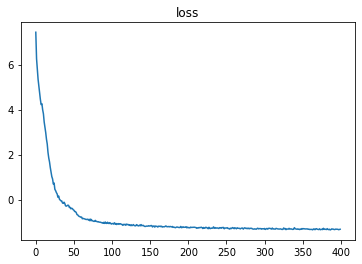

In [16]:
def mask_operation(i, n):
    return i < (n + MIN_N)
    
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain)) # with noise
        self.inputEmbedding = InputEmbedding((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain))
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        self.hid_net = simpleNN(hidden_state_dim + len(char_dict) + MAX_N + 1, hidden=128, out_size = hidden_state_dim, t = "mlp")
        self.h0 = nn.Parameter(torch.zeros(hidden_state_dim))
        
        input_dim_dict = {
            "img" : captchaHeight * captchaWidth,
        }
        var_dim_dict = {
            "num_char" : 1,
            "noise" : 1,
        }
        
        dependency_dict = {
            "num_char" : ["img"],
            "noise" : ["img"],
        }
        
        to_event_dict = {
            "num_char" : 0,
            "noise" : 1,
        }
        
        dist_type_dict = {
            "num_char" : ("cate", len(self.num_char_domain)),
            "noise" : "norm"
        }
        
        self.gmade_n = GMADE(input_dim_dict, dependency_dict, var_dim_dict, 
           dist_type_dict, to_event_dict, use_cuda=use_cuda, hidden_layers=3, hidden_sizes=1)
        
        
        input_dim_dict = {
            "img_embedded" : 1280,
            "hid" : hidden_state_dim,
            "noise" : 1
        }
        
        var_dim_dict = {
            "char" : 1, 
        }
        
        dependency_dict = {
            "char" : ["img_embedded", "hid", "noise"]
        }
        
        to_event_dict = {
            "char" : 0
        }
        
        dist_type_dict = {
           "char" : ("cate", len(self.char_dict))
        }
        
        self.gmade_char = GMADE(input_dim_dict, dependency_dict, var_dim_dict, 
           dist_type_dict, to_event_dict, use_cuda=use_cuda, hidden_layers=3, hidden_sizes=3)
            
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input

    # update from old captcha model/guide:
    # using mask to zero out index > num_char, this is a generalization of the previous version where we take the mean 
    # and assume num_char is the same for the entire batch

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        BS = img.shape[0]
        
        # posterior to the number of letters
        
        with pyro.plate("data", img.shape[0]):
            prob = self.numNet(img)
            #prob = torch.mean(prob, dim=0)
            N_index = pyro.sample("num_char", dist.Categorical(prob).to_event(0))
            N_index = torch.add(N_index, self.num_char_domain[0])
            
            # posterior to the noise
            noise_mean, noise_sig, noise_map = self.noiseNet(img)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, noise_map)
            h = self.h0.expand(BS, -1)
            
            for i in range(MAX_N):
                # tranform index to one-hot representation
                i_input = torch.tensor(i)
                if USE_CUDA:
                    i_input = i_input.cuda()
                i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                i_input = i_input.repeat(BS, 1)
                # whether the character has ends
                sample_mask = i < N_index
                charP_i = self.charNet(input_emb, h, noise_batch)
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(charP_i).mask(sample_mask).to_event(0))
                c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                # update the hidden state
                h = self.hid_net([h, c_i, i_input, sample_mask.float().unsqueeze(1)])
                
    def guide_gmade(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        
        img = observations["captcha"].float()
        BS = img.shape[0]
        # flatten representation of img
        img_raw = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
                
        with pyro.plate("data", img.shape[0]):
            
            input_dict = {
                "img" : img_raw
            }
            out_1 = self.gmade_n(input_dict, suffix="")
            N_index = out_1["num_char"]
            N_index = torch.add(N_index, self.num_char_domain[0])
            noise_batch = out_1["noise"]
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, None)
            h = self.h0.expand(BS, -1)
            #print(N_index, noise_batch)
            
            for i in range(MAX_N):
                # tranform index to one-hot representation
                i_input = torch.tensor(i)
                if USE_CUDA:
                    i_input = i_input.cuda()
                i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                i_input = i_input.repeat(BS, 1)
                # whether the character has ends
                sample_mask = i < N_index
                
                input_dict_char = {
                    "img_embedded" : input_emb,
                    "hid" : h,
                    "noise" : noise_batch
                }
                out_2 = self.gmade_char(input_dict_char, suffix="_"+str(i), mask_dict={"char" : sample_mask})
                c_i = out_2["char"]
                c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                h = self.hid_net([h, c_i, i_input, sample_mask.float().unsqueeze(1)])

            
    def model(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            for i in range(MAX_N):
                sample_mask = i < N_index
                num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                if self.use_cuda:
                    num_c_i = num_c_i.cuda()
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                sampled_c.append((sample_mask, c_i))
            # sample characters
            rendered_images = []
            for i in range(BS):
                chars = ""
                for j in range(MAX_N):
                    if sampled_c[j][0][i]:
                        chars += self.char_dict[sampled_c[j][1][i]]
                    else:
                        break
                rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                rendered_images.append(rendered_image)
                
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model, captchaModel.guide_gmade, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_metrics_noise_in_charnet_gmade_400.json")


Logs